In [6]:
import numpy as np
import math, json
from rdp import rdp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import tqdm.notebook as tq
import pickle
import rdb

In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

ModuleNotFoundError: No module named 'rdb'

In [ ]:
from PIL import Image, ImageDraw
import json
import numpy as np

def img_from_stroke(drawing):
    img_A = Image.new('RGB', (600, 600), (255, 255, 255)) 
    draw = ImageDraw.Draw(img_A) 
    for item in drawing:
        char = list(item.keys())[0]
        stroke = item[char]
        if len(stroke) == 1:
            x, y = stroke[0]
            stroke.append([x+5, y+5])
        for i, point in enumerate(stroke):
            if i == 0:
                x_prev, y_prev = point
                continue
            x, y = point 
            draw.line([x_prev, y_prev, x, y], fill=(0, 0, 0), width = 3)
            x_prev, y_prev = x, y
    return img_A

In [7]:
def apply_rdb(drawing, verbose = 0):
    new_drawing = []
    total_prev_strokes = 0
    total_post_strokes = 0
    for item in drawing:
        char = list(item.keys())[0]
        stroke = item[char]
        processed_stroke = []
        if len(stroke):
            if verbose:
                print('processing ', char)
            post_stroke = rdp(stroke, epsilon = 2.0)
            total_post_strokes += len(post_stroke)
            total_prev_strokes += len(stroke)
        new_drawing.append({char:post_stroke})
    if verbose:
        print('reduced from ', total_prev_strokes, ' to ', total_post_strokes)
    return new_drawing

In [8]:
import glob
npy_files = glob.glob('dataset/**/*.json')

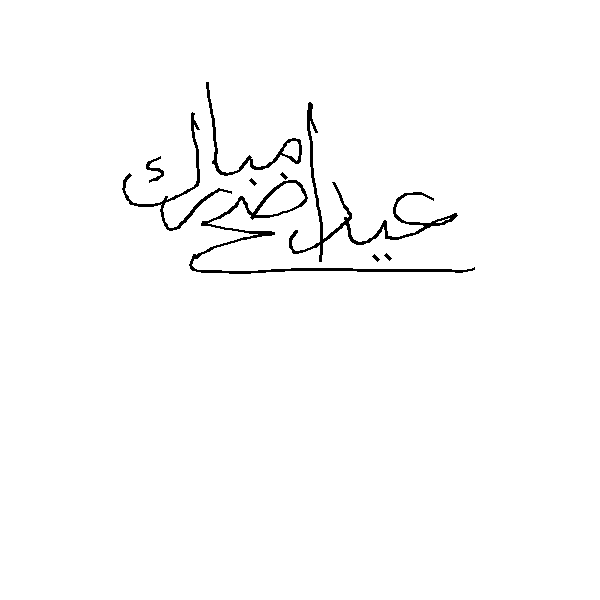

In [9]:
file = np.random.choice(npy_files)
drawing = json.load(open(file))
new_drawing = apply_rdb(drawing, verbose = 0)
img_from_stroke(drawing)

In [12]:
def add_z(drawing):
    new_data = []
    x_prev, y_prev = None, None
    for item in drawing:
        char = list(item.keys())[0]
        if x_prev is None:
            x_prev, y_prev = item[char][0]
        stroke = item[char]
        x_data = []
        y_data = []
        segments = []
        
        if len(stroke) == 1:
            x, y = stroke[0]
            stroke.append([x+1, y+1])
            
        for i, point in enumerate(stroke):
            x, y = point
            if i == len(stroke) - 1:
                z = 1
            else:
                z = 0
            if i >=0:
                segments.append([x-x_prev, y-y_prev, z])
            x_prev, y_prev = [x, y]
        new_data += segments
    return np.array(new_data)

In [15]:
def create_dataset():
    train_data = []
    valid_data = []
    test_data = []
    count = 0 
    valid_size = 100 
    test_size = 100
    pbar = tq.tqdm(total = 2500)
    for file in glob.glob('dataset/**/*.json'):
        drawing = json.load(open(file))
        new_drawing = apply_rdb(drawing)
        strokes = add_z(new_drawing)
        
        count += 1
        pbar.update(1)
        if 'train' in file:
            train_data.append(strokes)
        elif 'valid' in file:
            valid_data.append(strokes)
        elif 'test' in file:
            test_data.append(strokes)
        else:
            pbar.close()
            break
  
    print("save dataset")
    with open('dataset.npz', 'wb') as f:
        pickle.dump({'train':train_data, 'valid':valid_data, 'test':test_data}, f, protocol=2)

In [16]:
create_dataset()

save dataset
